# Include Categorical Variables

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('/home/gonde94/Downloads/archive/data.csv')

In [3]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


### How many unique values per categorical variable?

In [4]:
for c in df.columns:
    if df[c].dtypes == 'object':
        unique = len(df[c].unique())
        print("Feature '{c}' has {unique} unique categories".format(
        c=c, unique=unique))

Feature 'date' has 70 unique categories
Feature 'street' has 4525 unique categories
Feature 'city' has 44 unique categories
Feature 'statezip' has 77 unique categories
Feature 'country' has 1 unique categories


In [15]:
df['city'].value_counts().sort_values(ascending=False).head(10)

Seattle        1573
Renton          293
Bellevue        286
Redmond         235
Issaquah        187
Kirkland        187
Kent            185
Auburn          176
Sammamish       175
Federal Way     148
Name: city, dtype: int64

### Date, street and country are unlikely to be very useful. Drop them. 

In [7]:
df.drop(['date','street','country'],axis=1,inplace=True)

### Create dummy variables for city and statezip

In [8]:
df_objs = df.select_dtypes(include='object')
df_nums = df.select_dtypes(exclude='object')

In [9]:
df_objs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   city      4600 non-null   object
 1   statezip  4600 non-null   object
dtypes: object(2)
memory usage: 72.0+ KB


In [10]:
df_objs = pd.get_dummies(df_objs)

In [11]:
final_df = pd.concat([df_nums,df_objs],axis=1)

In [14]:
final_df.columns.values.tolist()

['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'city_Algona', 'city_Auburn', 'city_Beaux Arts Village', 'city_Bellevue', 'city_Black Diamond', 'city_Bothell', 'city_Burien', 'city_Carnation', 'city_Clyde Hill', 'city_Covington', 'city_Des Moines', 'city_Duvall', 'city_Enumclaw', 'city_Fall City', 'city_Federal Way', 'city_Inglewood-Finn Hill', 'city_Issaquah', 'city_Kenmore', 'city_Kent', 'city_Kirkland', 'city_Lake Forest Park', 'city_Maple Valley', 'city_Medina', 'city_Mercer Island', 'city_Milton', 'city_Newcastle', 'city_Normandy Park', 'city_North Bend', 'city_Pacific', 'city_Preston', 'city_Ravensdale', 'city_Redmond', 'city_Renton', 'city_Sammamish', 'city_SeaTac', 'city_Seattle', 'city_Shoreline', 'city_Skykomish', 'city_Snoqualmie', 'city_Snoqualmie Pass', 'city_Tukwila', 'city_Vashon', 'city_Woodinville', 'city_Yarrow Point', 'statezip_WA 98001', 'statezip_WA

## Compare different base models performance 

In [31]:
y = final_df['price']
X = final_df.drop('price', axis=1)

In [32]:
from sklearn.model_selection import train_test_split

### Create train, validation and test sets

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [34]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [35]:
X_train.shape

(3220, 133)

In [36]:
X_val.shape

(690, 133)

In [37]:
X_test.shape

(690, 133)

In [38]:
from sklearn.preprocessing import StandardScaler

In [39]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_val = scaler.transform(X_val)
scaled_X_test = scaler.transform(X_test)

In [84]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [41]:
models = []
models.append(('LR', LinearRegression()))
models.append(('CART', RandomForestRegressor()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('SVM', SVR()))
models.append(('XGB', xgb.XGBRegressor()))

In [42]:
results = []
names = []

for name, model in models:
    kfold = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(),cv_results.std())

[Text(1, 0, 'LR'), Text(2, 0, 'CART'), Text(3, 0, 'KNN'), Text(4, 0, 'SVM'), Text(5, 0, 'XGB')]

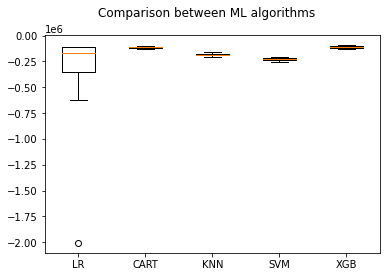

In [43]:
fig = plt.figure()
fig.suptitle('Comparison between ML algorithms')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

#one bad linear regression model makes the chart hard to see

In [44]:
MLA = [LinearRegression(),
       RandomForestRegressor(),
       KNeighborsRegressor(),
       SVR(),
       xgb.XGBRegressor()
]

In [49]:
MLA_cols = []
MLA_compare = pd.DataFrame(columns = MLA_cols)

row_index = 1
for alg in MLA:
    predicted = alg.fit(X_train, y_train).predict(X_val)
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA used'] = MLA_name
    MLA_compare.loc[row_index, 'MAE'] = mean_absolute_error(y_val, predicted)
    row_index += 1

In [50]:
MLA_compare.sort_values(by=['MAE']
#xgboost and random forests do about the same. All the others do worse with categorical variables

,MLA used,MAE
5,XGBRegressor,107964.057095
2,RandomForestRegressor,113351.630435
3,KNeighborsRegressor,188065.226307
4,SVR,219882.729240
1,LinearRegression,533656.793838


## As stacking offered little benefit, test out XGB for parameter tuning

In [87]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

In [85]:
xgb = xgb.XGBRegressor()

In [65]:
param_grid = {'learning_rate': [0.05, 0.1, 0.2],
             'max_depth': [3, 4, 5, 6],
             'n_estimators': [50, 80, 100, 120, 150],
             'alpha': [0.5, 1, 5, 10],
             'objective': ['reg:linear']}

In [68]:
grid_model = GridSearchCV(xgb, param_grid, scoring='neg_mean_absolute_error',
                         cv=3, verbose=1)

In [69]:
grid_model.fit(X_train, y_train)

Fitting 3 folds for each of 240 candidates, totalling 720 fits
[17:01:10] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:01:10] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:01:11] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:01:11] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:01:12] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:01:13] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:01:13] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:01:14] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg

[17:02:14] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:02:14] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:02:15] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:02:16] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:02:17] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:02:18] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:02:19] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:02:20] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:02:20] WARNING: ../src/objective/regression_

[17:03:19] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:03:20] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:03:20] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:03:21] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:03:22] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:03:23] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:03:24] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:03:25] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:03:26] WARNING: ../src/objective/regression_

[17:04:24] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:04:25] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:04:26] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:04:28] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:04:28] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:04:29] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:04:29] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:04:30] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:04:31] WARNING: ../src/objective/regression_

[17:05:31] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:05:32] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:05:33] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:05:34] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:05:35] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:05:36] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:05:37] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:05:39] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:05:40] WARNING: ../src/objective/regression_

[17:06:42] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:06:42] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:06:43] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:06:43] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:06:44] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:06:46] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:06:47] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:06:48] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:06:49] WARNING: ../src/objective/regression_

[17:07:47] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:07:49] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:07:50] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:07:51] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:07:53] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:07:55] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:07:56] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:07:57] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:07:57] WARNING: ../src/objective/regression_

[17:08:55] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:56] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:56] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:57] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:58] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:58] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:59] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:09:00] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:09:01] WARNING: ../src/objective/regression_

[17:10:01] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:10:02] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:10:03] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:10:04] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:10:04] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:10:05] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:10:05] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:10:06] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:10:07] WARNING: ../src/objective/regression_

[17:11:07] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:11:09] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:11:10] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:11:11] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:11:12] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:11:13] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:11:14] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:11:16] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:11:17] WARNING: ../src/objective/regression_

[17:12:18] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:12:18] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:12:19] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:12:19] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:12:20] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:12:21] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:12:22] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:12:23] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:12:24] WARNING: ../src/objective/regression_

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n...
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                 

In [70]:
grid_model.best_params_

{'alpha': 5, 'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 150, 'objective': 'reg:linear'}

In [88]:
model = XGBRegressor(learning_rate=0.2, max_depth=4, n_estimators=150, alpha=5)

In [90]:
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

In [91]:
mean_absolute_error(y_val, y_pred) #an improvement of $5000 from before, $13000 from base

106673.21309633914

In [92]:
np.sqrt(mean_squared_error(y_val, y_pred))

209097.09527757685

In [95]:
from xgboost import plot_importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

<Figure size 2016x2016 with 0 Axes>

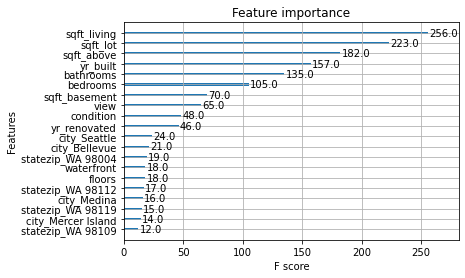

In [105]:
plt.figure(figsize=(28,28))
plot_importance(model, max_num_features=20)

## Feature selection by feature importance

In [114]:
from numpy import sort
from sklearn.feature_selection import SelectFromModel

#Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBRegressor()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_val = selection.transform(X_val)
    predictions = selection_model.predict(select_X_val)
    MAE = mean_absolute_error(y_val, predictions)
    print("Thresh:",thresh, 'n=', select_X_train.shape[1], 'MAE=', MAE)

/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0 n= 133 MAE= 107964.05709543334


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0002463094 n= 83 MAE= 106341.51811261015


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0004977776 n= 82 MAE= 107276.55386895074


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0006698568 n= 81 MAE= 107158.35301976594


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0006724594 n= 80 MAE= 106502.3171275558


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.00080874446 n= 79 MAE= 105991.17875530652


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.001032502 n= 78 MAE= 106276.26589340725


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0011901767 n= 77 MAE= 107241.829412429


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0012250121 n= 76 MAE= 107681.02170183117


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.001231976 n= 75 MAE= 107442.47103841812


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0012554066 n= 74 MAE= 109028.11895550435


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0013476893 n= 73 MAE= 106858.23938080942


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0014871808 n= 72 MAE= 108323.84828068552


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0016367645 n= 71 MAE= 108392.02943507391


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0020702793 n= 70 MAE= 108899.07446451232


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0020896008 n= 69 MAE= 109574.92684222972


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0021330002 n= 68 MAE= 108493.42539253479


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0022872123 n= 67 MAE= 108404.17839298768


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0023910163 n= 66 MAE= 108630.83734905653


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0024210452 n= 65 MAE= 108591.55186487464


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0024218475 n= 64 MAE= 105895.7068769529


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.00247744 n= 63 MAE= 109630.98711170435


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.00252898 n= 62 MAE= 109573.99573942175


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0025669844 n= 61 MAE= 107202.64847945797


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0027097831 n= 60 MAE= 111836.17930486558


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0029809524 n= 59 MAE= 110307.26422858551


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0030704597 n= 58 MAE= 112760.74609796739


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0034147068 n= 57 MAE= 114144.71456993769


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0035082991 n= 56 MAE= 110808.64352525074


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.00351864 n= 55 MAE= 109474.36513102899


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0035624187 n= 54 MAE= 110989.56904860145


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0037330054 n= 53 MAE= 111908.98551146378


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0037539862 n= 52 MAE= 113020.40489552174


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0038114155 n= 51 MAE= 112343.66762197102


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0038274436 n= 50 MAE= 113769.79134253261


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.004070902 n= 49 MAE= 113305.85696753261


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0041901716 n= 48 MAE= 113511.79826055797


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0042829113 n= 47 MAE= 112465.88999515942


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0044126925 n= 46 MAE= 115555.61183619204


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0044531864 n= 45 MAE= 113380.93822885508


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.005125106 n= 44 MAE= 111697.61530463914


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0053474796 n= 43 MAE= 111887.84511291304


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0053510983 n= 42 MAE= 113456.11263050145


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0054985955 n= 41 MAE= 111381.99460717537


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.005560675 n= 40 MAE= 115865.76303475653


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.006371351 n= 39 MAE= 115738.46307034059


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.006427584 n= 38 MAE= 114790.42632139639


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.006557307 n= 37 MAE= 116870.53723086159


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.006607632 n= 36 MAE= 117097.47914068986


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0066097695 n= 35 MAE= 119834.96471048116


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.0067261257 n= 34 MAE= 119549.8301257442


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.008506344 n= 33 MAE= 119166.82063751957


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.008530307 n= 32 MAE= 121650.5980315913


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.009051823 n= 31 MAE= 119890.81723448986


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.009714032 n= 30 MAE= 120132.65495716594


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.010267664 n= 29 MAE= 125367.50167742465


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.010503106 n= 28 MAE= 121258.02255604783


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.010617487 n= 27 MAE= 123027.41295082537


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.010793937 n= 26 MAE= 128166.46478722102


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.010819898 n= 25 MAE= 129505.27623962174


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.011203115 n= 24 MAE= 126222.57596127881


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.012115765 n= 23 MAE= 128633.01236960363


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.012343638 n= 22 MAE= 130056.85876025508


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.013131229 n= 21 MAE= 130683.89373911885


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.013162781 n= 20 MAE= 132317.62854437248


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.013295831 n= 19 MAE= 132586.41651991595


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.016545743 n= 18 MAE= 133934.04414672754


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.017165672 n= 17 MAE= 137364.89714718045


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.021290466 n= 16 MAE= 137183.2616965464


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.02243009 n= 15 MAE= 139768.47817073116


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.022665555 n= 14 MAE= 141490.78710415508


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.023339398 n= 13 MAE= 146287.25866212609


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.023435649 n= 12 MAE= 148712.3120022529


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.029788395 n= 11 MAE= 151089.68689873407


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.030283462 n= 10 MAE= 154193.85409540002


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.03143072 n= 9 MAE= 157920.04978369785


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.035948124 n= 8 MAE= 158603.98011819494


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.037751082 n= 7 MAE= 163756.4712527058


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.040923875 n= 6 MAE= 166264.6023102239


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.04401163 n= 5 MAE= 170564.51685958987


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.046869494 n= 4 MAE= 182098.420948258


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.05171622 n= 3 MAE= 181944.777809671


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh: 0.08567353 n= 2 MAE= 182327.4529681855
Thresh: 0.09250095 n= 1 MAE= 230526.09049670142


/home/gonde94/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [ ]:
#79 features -> MAE of $105991